## COMP5625M* Project - News Summary Dissertation [100 marks]
update module code

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.



### Imports

In [10]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
import string
import random

import numpy as np 
import pandas as pd

import json

DATASET = "./Dataset/"

Detect which device (CPU/GPU) to use.

In [3]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Overview

> 1. Dataset preprocessing
> 2. Dataloader
> 3. RNN model definition
> 4. Model training
> 5. Model prediction evaluation
> 6. Dataset Exploration
> 7. Dataset modification/Data Augmentation
> 8. Model improvement
> 9. Model finalisation and evaluation


# Data preprocessing

In [4]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [5]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

DATA_DIR = "SSN/papers.SSN.jsonl"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        # df = array of all the file names

        self.df = df
        self.transform = transform
        # --> your code here!


    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        image = Image.open(os.path.join(IMAGE_DIR, filename)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        

        # --> your code here!


        return image, filename

    def __len__(self):
        return len(self.df)
    

# Dataloader

# RNN Model definition

In [6]:
class RNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(RNN, self).__init__()
        # Your code here!
#         resnet = models.resnet50(pretrained=True)
#         self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
#         self.linear = nn.Linear(2048,256)
        #print(resnet)

        # TO COMPLETE
        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)

        
    def forward(self, images):
        """Extract feature vectors from input images."""

        # TO COMPLETE
        # remember no gradients are needed
#         with torch.no_grad():
#             features = self.resnet(images)
#             features = features.reshape(features.size(0), -1)
#             features = self.linear(features)
#         return features


# Model training

# Model Evaluation

# Dataset Exploration

In [7]:
dataset_path = DATASET+DATA_DIR

In [9]:
with open(dataset_path) as f:
    lines = f.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']
df_inter

,json_element
0,"{""paper_id"": ""4650265"", ""title"": ""XGBoost: A S..."
1,"{""paper_id"": ""9195903"", ""title"": ""Robust Face ..."
2,"{""paper_id"": ""119332442"", ""title"": ""Modulation..."
3,"{""paper_id"": ""13494452"", ""title"": ""Free evolut..."
4,"{""paper_id"": ""119269876"", ""title"": ""Light Dila..."
...,...
140794,"{""paper_id"": ""12157610"", ""title"": ""Minimal and..."
140795,"{""paper_id"": ""14690185"", ""title"": ""AN OBSTRUCT..."
140796,"{""paper_id"": ""15296646"", ""title"": ""Direct Dete..."
140797,"{""paper_id"": ""119576690"", ""title"": ""PCA by Opt..."


In [11]:
df_inter['json_element'].apply(json.loads)

0         {'paper_id': '4650265', 'title': 'XGBoost: A S...
1         {'paper_id': '9195903', 'title': 'Robust Face ...
2         {'paper_id': '119332442', 'title': 'Modulation...
3         {'paper_id': '13494452', 'title': 'Free evolut...
4         {'paper_id': '119269876', 'title': 'Light Dila...
                                ...                        
140794    {'paper_id': '12157610', 'title': 'Minimal and...
140795    {'paper_id': '14690185', 'title': 'AN OBSTRUCT...
140796    {'paper_id': '15296646', 'title': 'Direct Dete...
140797    {'paper_id': '119576690', 'title': 'PCA by Opt...
140798    {'paper_id': '119301470', 'title': 'Turbulent ...
Name: json_element, Length: 140799, dtype: object

In [12]:
df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))

In [13]:
df_final

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,[tree boosting is a highly effective and widel...,"[introduction, tree boosting in a nutshell, re...",[],[[machine learning and data - driven approache...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"[face alignment , which is the task of finding...","[introduction, previous work, our approach, su...",[Computer science],[[face alignment refers to finding the pixel l...
2,119332442,Modulation instability associated nonlinear dy...,[we study pattern - forming nonlinear dynamics...,"[introduction, modulation instability of becs ...",[Physics],[[modulation instability ( mi ) is one of the ...
3,13494452,Free evolution on algebras with two states,[the key result in the paper concerns two tran...,"[introduction, preliminaries, polynomials and ...",[Mathematics],[[in a series of papers belinschi and nica int...
4,119269876,Light Dilaton at Fixed Points and Ultra Light ...,[we investigate the infrared dynamics of a non...,"[introduction, a comment on the large nn and n...",[Physics],[[understanding strong dynamics constitutes a ...
...,...,...,...,...,...,...
140794,12157610,Minimal and Maximal Operator Spaces and Operat...,[we examine k - minimal and k - maximal operat...,"[introduction, quantum information theory prel...",[Mathematics],[[a primary goal of this paper is to formally ...
140795,14690185,AN OBSTRUCTION TO ASYMPTOTIC SEMISTABILITY AND...,"[in this paper , we consider an obstruction to...","[introduction, statement of results, an obstru...",[Mathematics],[[for a polarized algebraic manifold inlinefor...
140796,15296646,Direct Detection of Neutralino Dark Matter and...,[we compare predictions for the spin - indepen...,"[introduction, msugra, more general models, co...",[Physics],[[the minimal supersymmetric standard model ( ...
140797,119576690,PCA by Optimisation of Symmetric Functions has...,[principal component analysis ( pca ) finds th...,"[introduction, pca by determinant optimisation...",[Mathematics],"[[let inlineform0 be a data matrix , with rows..."


In [15]:
df_final.to_csv("./Dataset/SSN/Reorganised_Dataset.csv", encoding='utf-8', index=False)

In [24]:
train_df = pd.read_csv(DATASET+DATA_DIR)

In [25]:
train_df

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...,...
287108,fffdfb56fdf1a12d364562cc2b9b1d4de7481dee,By . James Rush . Former first daughter Chelse...,Chelsea Clinton said question of running for o...
287109,fffeecb8690b85de8c3faed80adbc7a978f9ae2a,An apologetic Vanilla Ice has given his first ...,"Vanilla Ice, 47 - real name Robert Van Winkle ..."
287110,ffff5231e4c71544bc6c97015cdb16c60e42b3f4,America's most lethal sniper claimed he wished...,America's most lethal sniper made comment in i...
287111,ffff924b14a8d82058b6c1c5368ff1113c1632af,"By . Sara Malm . PUBLISHED: . 12:19 EST, 8 Mar...",A swarm of more than one million has crossed b...


In [58]:
def get_df_lengths(df):
    ratio = []
    for i,row in df.iterrows():
        article = len(row["article"].split())
        highlight = len(row["highlights"].split())
        if (i==137538):
            print(row["article"])
            print("---------------------")
            print(row["highlights"])
        ratio.append(highlight/article)
    return ratio

In [59]:
ratio = get_df_lengths(train_df)

Downton Abbey's famously grim butler, Mr Bates .
---------------------
And now for the good news . . . Following a particularly grim week, here’s a compendium of some of the world’s most comforting headlines: .
Supermodel Smiles On Catwalk .
Jack Russell Dog Welcomes Stranger .
Child At Funfair ‘Delighted’ By Goldfish .
Katie Price Breasts ‘Roughly Same Size As Last Week’ Say Experts .
Teenager Looks Up From Phone, Greets Parent .
Political Pundits Agree To Stop Discussing Hung Parliament For Next Three Months .
Diner Finishes His Curly Kale .
Pensioner Looks Great In Party Hat .
Celebrity Fails To Compare Life To Roller-coaster .
Pet Hamster Repays Child’s Affection .
‘Cheer Up, It May Never Happen’ — Downton’s Mr Bates Enjoys Belly-laugh .
Style Journalist Fails To Employ The Word ‘Iconic’
Sally Bercow Goes Out On Town, Retains Dignity .
Entire Windfarm Operates According To Plan .
Miley Cyrus Feels A Bit Chilly, Opts For Extra Layer .


In [47]:
ratio

[0.18686868686868688,
 0.09693877551020408,
 0.0853960396039604,
 0.09981167608286252,
 0.11551724137931034,
 0.12574850299401197,
 0.03099730458221024,
 0.08695652173913043,
 0.09688013136288999,
 0.06306306306306306,
 0.09338235294117647,
 0.09428129829984544,
 0.04805914972273567,
 0.14903846153846154,
 0.05941845764854614,
 0.12058212058212059,
 0.03619909502262444,
 0.05114029025570145,
 0.14392059553349876,
 0.09248554913294797,
 0.11290322580645161,
 0.06223175965665236,
 0.025252525252525252,
 0.0670807453416149,
 0.07357357357357357,
 0.059931506849315065,
 0.0497335701598579,
 0.04749512036434613,
 0.22916666666666666,
 0.12189616252821671,
 0.10119840213049268,
 0.04323094425483504,
 0.09049773755656108,
 0.022063208109719738,
 0.10561797752808989,
 0.16293929712460065,
 0.058163265306122446,
 0.11014492753623188,
 0.04020979020979021,
 0.13213213213213212,
 0.1079734219269103,
 0.05200945626477541,
 0.07241379310344828,
 0.07616707616707617,
 0.09510869565217392,
 0.1128472

In [50]:
max(ratio)

19.0

In [51]:
ratio.index(max(ratio))

137538

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


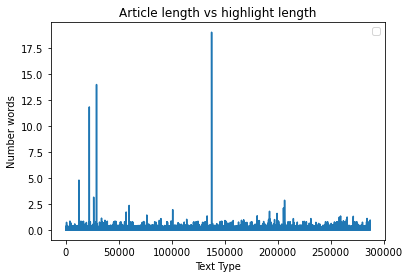

In [48]:
sep = np.arange(len(art_len))

plt.plot(ratio)

plt.xlabel("Text Type")
plt.ylabel("Number words")
plt.title("Article length vs highlight length")
plt.legend()
plt.show()

In [29]:
train_df.isnull().any()

id            False
article       False
highlights    False
dtype: bool

After exploring, all highlight:article ratio being more than 1.0 means the summary text is producing more text than the original text, this defeats the purpose of the model, therefore all data with a ratio of more than or equal to 1.0 will be omitted.

# Dataset modification/Data Augmentation

In [ ]:
aug_data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

# Model improvement/Retrain

# Model Finalisation and Evaluation